In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer as StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, GaussianNoise
import tensorflow.keras.backend as K
import tensorflow as tf
from functools import partial

Welcome to JupyROOT 6.10/08


In [2]:
n_particles = 10000/2
p = np.random.uniform(0.3,10.,n_particles)
mp = np.random.uniform(1/10.,1/0.3,n_particles)
p_mp = 1./mp 

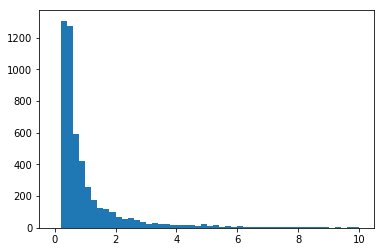

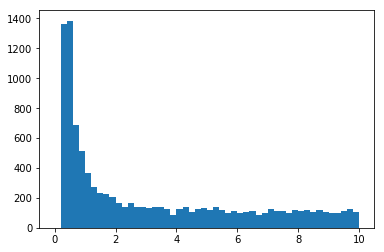

In [3]:
plt.hist(p_mp,50,range=(0.,10.))
plt.show()
p_ges = np.concatenate([p,p_mp])
plt.hist(p_ges,50,range=(0,10))
plt.show()

In [4]:
mass_pi = 0.139
mass_mu = 0.105
mass_e = 0.000511
mass_p = 0.938
mass_K = 0.494
masses = [mass_pi, mass_mu, mass_e, mass_p, mass_K]
masses

[0.139, 0.105, 0.000511, 0.938, 0.494]

In [5]:
signals = []
for mass in masses:
    ITS_tmp = []
    TPCROC0_tmp = []
    TPCROC1_tmp = []
    TPCROC2_tmp = []
    TRD_tmp = []
    TOF_tmp = []
    for p in p_ges:
        bg = p/mass
        beta = bg/math.sqrt(1.+ bg*bg);
        BBS = ROOT.AliExternalTrackParam.BetheBlochSolid(bg)
        BBA = ROOT.AliExternalTrackParam.BetheBlochAleph(bg)
        ITS_tmp.append(np.random.normal(BBS,0.1*BBS) ) ## ITS dEdx = smeared gaus 10% 
        TPCROC0_tmp.append(np.random.normal(BBA,0.1*BBA) )## TPC dEdx = smeared gaus 10% for 1st layer
        TPCROC1_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 2nd layer
        TPCROC2_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 3d layer
        TRD_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TRD dEdx = smeared gaus 10% 
        TOF_tmp.append(np.random.normal(beta,0.1*beta) )  ## TOF - smeared with .... gaussian
    signals.append({'ITS': ITS_tmp, 'TPCROC0': TPCROC0_tmp, 'TPCROC1': TPCROC1_tmp, 'TPCROC1': TPCROC1_tmp, 
                    'TPCROC2': TPCROC2_tmp, 'TRD': TRD_tmp, 'TOF': TOF_tmp})

[]

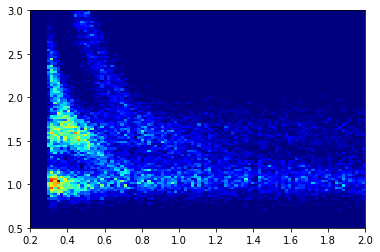

In [6]:
df_list=[]
for i, val in enumerate(masses):
    df = pd.DataFrame.from_dict(signals[i])
    df['p'] = pd.Series(p_ges, index=df.index)
    df['particle'] = pd.Series(i, index=df.index)
    df_list.append(df)
df_all = pd.concat([df_list[0],df_list[2],df_list[3],df_list[4]], ignore_index=True)
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.plot()

In [7]:
N=len(df_all)
probability = 0.95

flips_raw = (1*(np.random.random(size=6*N)<probability)).reshape(6,-1)

flips=flips_raw[0]
for i in range(1,6):
    # (1<<i = 2**i)
    flips=flips_raw[i]*(1<<i) + flips


df_all.loc[:,'flips']=flips
df_all.head(5)

,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips
0,0.001493,1.139668,1.019214,1.067614,1.024972,0.936833,0.693183,0,63
1,0.002401,0.944738,1.339263,1.400783,1.323482,1.387548,6.764429,0,63
2,0.002118,0.911158,1.277372,1.340589,1.481076,1.343896,4.878680,0,63
3,0.002202,0.963982,1.362786,1.112496,1.151116,1.296877,4.466496,0,63
4,0.001995,0.999167,1.455165,1.368103,1.362519,1.388860,7.961384,0,63


In [8]:
# prepare "flips-Data" and weights
for i ,name in enumerate(['ITS','TOF','TPCROC0','TPCROC1','TPCROC2','TRD']):
    # calculate "flip= 0/1"
    f=(np.array(df_all['flips'])>>i)&1
    # if f=0 substitute value by mean
    m=df_all[name].mean()
    df_all.loc[:,name+'_mr']= df_all[name].multiply(f,axis='index')+m*(1-f) #mean replaced
    df_all.loc[:,name+'_w']=1.0*f #weight
    df_all.loc[:,name+'_0']= df_all[name].multiply(f,axis='index') #zeros
    
# generate data for stage 2
df_stage_2=df_all.copy()
df_stage_3=df_all.copy()
df_all[df_all['particle']==0].head(10)

,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips,ITS_mr,...,TPCROC0_0,TPCROC1_mr,TPCROC1_w,TPCROC1_0,TPCROC2_mr,TPCROC2_w,TPCROC2_0,TRD_mr,TRD_w,TRD_0
0,0.001493,1.139668,1.019214,1.067614,1.024972,0.936833,0.693183,0,63,0.001493,...,1.019214,1.067614,1.0,1.067614,1.024972,1.0,1.024972,0.936833,1.0,0.936833
1,0.002401,0.944738,1.339263,1.400783,1.323482,1.387548,6.764429,0,63,0.002401,...,1.339263,1.400783,1.0,1.400783,1.323482,1.0,1.323482,1.387548,1.0,1.387548
2,0.002118,0.911158,1.277372,1.340589,1.481076,1.343896,4.878680,0,63,0.002118,...,1.277372,1.340589,1.0,1.340589,1.481076,1.0,1.481076,1.343896,1.0,1.343896
3,0.002202,0.963982,1.362786,1.112496,1.151116,1.296877,4.466496,0,63,0.002202,...,1.362786,1.112496,1.0,1.112496,1.151116,1.0,1.151116,1.296877,1.0,1.296877
4,0.001995,0.999167,1.455165,1.368103,1.362519,1.388860,7.961384,0,63,0.001995,...,1.455165,1.368103,1.0,1.368103,1.362519,1.0,1.362519,1.388860,1.0,1.388860
5,0.001891,0.909673,1.367861,1.356773,1.452914,1.310196,7.660722,0,61,0.001891,...,1.367861,1.356773,1.0,1.356773,1.452914,1.0,1.452914,1.310196,1.0,1.310196
6,0.002167,0.843813,1.313601,1.154777,1.108875,1.384489,6.382428,0,63,0.002167,...,1.313601,1.154777,1.0,1.154777,1.108875,1.0,1.108875,1.384489,1.0,1.384489
7,0.002112,1.009364,1.247889,1.319914,1.333058,1.258059,7.293260,0,63,0.002112,...,1.247889,1.319914,1.0,1.319914,1.333058,1.0,1.333058,1.258059,1.0,1.258059
8,0.002028,1.128233,1.415524,1.203686,1.199855,0.905107,5.730047,0,63,0.002028,...,1.415524,1.203686,1.0,1.203686,1.199855,1.0,1.199855,0.905107,1.0,0.905107
9,0.002316,1.101442,1.318660,1.156376,1.079181,1.193297,5.949201,0,63,0.002316,...,1.318660,1.156376,1.0,1.156376,1.079181,1.0,1.079181,1.193297,1.0,1.193297


In [9]:
train, test =train_test_split(df_all, test_size=0.5)

# Create autoencoders

In [10]:
def custom_loss(y_true, y_pred,weights):
    return K.mean(K.square((y_true - y_pred)*weights))

inputs = Input(shape=(6,))
inputw = Input(shape=(6,))
noise = GaussianNoise(0.2)(inputs)
enc1   = Dense(units=64, activation='selu')(noise)
enc2   = Dense(units=64, activation='selu')(enc1)
enc3   = Dense(units=64, activation='selu')(enc2)
enc4   = Dense(units=64, activation='selu')(enc3)
layer0 = Dense(units=2 , activation='selu')(enc4)
dec1   = Dense(units=64, activation='selu')(layer0)
dec2   = Dense(units=64, activation='selu')(dec1)
dec3   = Dense(units=64, activation='selu')(dec2)
dec4   = Dense(units=64, activation='selu')(dec3)
outputs= Dense(units=6, activation='linear')(dec4)

c_loss = partial(custom_loss, weights=inputw)
        
modelpt = Model(inputs=inputs,outputs=outputs)
models2 = Model(inputs=inputs,outputs=outputs)
modell = Model(inputs=inputs,outputs=outputs)
model0 = Model(inputs=inputs,outputs=outputs)
model1 = Model(inputs=[inputs,inputw],outputs=outputs)
modelpt.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
models2.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
modell.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
model0.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
model1.compile(loss=c_loss,
              optimizer='adam',
              metrics=['mse'])

In [11]:
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
__________

# perfect tracks

In [12]:
train_pt = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_pt = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
scaler_pt = StandardScaler()
scaler_pt.fit( train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]])

QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
          output_distribution='uniform', random_state=None,
          subsample=100000)

In [13]:
modelpt.fit(scaler_pt.transform(train_pt), scaler_pt.transform(train_pt), epochs=5, batch_size=32, 
          validation_data=[scaler_pt.transform(test_pt),scaler_pt.transform(test_pt)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 7s 345us/step - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 2/5
20000/20000 [==============================] - 6s 279us/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 3/5
20000/20000 [==============================] - 6s 280us/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 4/5
20000/20000 [==============================] - 6s 278us/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 5/5
20000/20000 [==============================] - 6s 277us/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0116 - val_mean_squared_error: 0.0116


2019-01-29 16:54:54.934379: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: FMA


In [14]:
out = scaler_pt.inverse_transform(modelpt.predict(scaler_pt.transform(test_pt)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips,...,TPCROC2_0,TRD_mr,TRD_w,TRD_0,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,10244,0.002864,1.035537,1.468154,1.576882,1.633345,1.399334,1.520442,2,63,...,1.633345,1.399334,1.0,1.399334,0.002627,1.056887,1.580247,1.528739,1.587357,1.545962
1,38092,0.003103,0.653779,2.108281,1.730810,1.889418,1.668988,0.375478,4,63,...,1.889418,1.668988,1.0,1.668988,0.003250,0.809449,1.733503,1.769253,1.834429,1.770820
2,1997,0.002626,1.082544,1.111228,1.293733,1.057884,1.240914,4.078123,0,63,...,1.057884,1.240914,1.0,1.240914,0.001959,1.041756,1.247596,1.228638,1.209697,1.214116


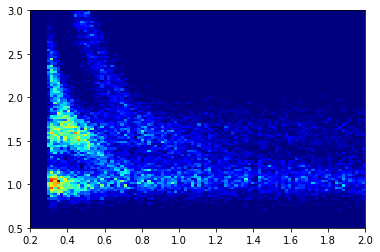

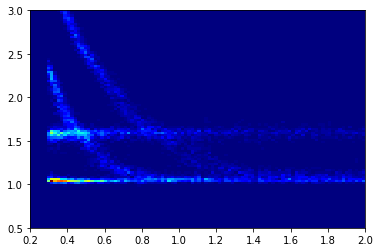

In [15]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC2_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# Train with zeros

In [16]:
train_0 = train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]]
test_0 = test[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]]
scaler_0 = StandardScaler()
scaler_0.fit( train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]])
#scaler_0.fit( train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]) 

QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
          output_distribution='uniform', random_state=None,
          subsample=100000)

In [17]:
train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]].head()

,ITS_0,TOF_0,TPCROC0_0,TPCROC1_0,TPCROC2_0,TRD_0
3143,0.002226,0.962858,1.136128,1.410310,1.520806,1.344206
13417,0.002902,0.832841,1.492102,1.689973,1.639307,1.569610
14101,0.003399,0.915694,1.601814,1.681639,1.503328,1.355203
38550,0.001684,0.917915,1.034174,0.966821,0.845766,1.011127
17747,0.002516,1.043539,1.394554,1.637954,1.526337,1.752949


In [18]:
train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]].head()


,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD
3143,0.002226,0.962858,1.136128,1.410310,1.520806,1.344206
13417,0.002902,0.832841,1.492102,1.689973,1.639307,1.569610
14101,0.003399,0.915694,1.601814,1.681639,1.503328,1.355203
38550,0.001684,0.917915,1.034174,0.966821,0.845766,1.011127
17747,0.002516,1.043539,1.394554,1.637954,1.526337,1.752949


In [19]:
model0.fit(scaler_0.transform(train_0), scaler_0.transform(train_0), epochs=5, batch_size=32, 
          validation_data=[scaler_0.transform(test_0),scaler_0.transform(test_0)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 27s 1ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 2/5
20000/20000 [==============================] - 8s 392us/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 3/5
20000/20000 [==============================] - 5s 270us/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 4/5
20000/20000 [==============================] - 5s 269us/step - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 5/5
20000/20000 [==============================] - 6s 286us/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0206 - val_mean_squared_error: 0.0206


In [20]:
out = scaler_0.inverse_transform(model0.predict(scaler_0.transform(test_0)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

,level_0,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,...,TPCROC2_0,TRD_mr,TRD_w,TRD_0,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,0,10244,0.002864,1.035537,1.468154,1.576882,1.633345,1.399334,1.520442,2,...,1.633345,1.399334,1.0,1.399334,0.002621,1.028522,1.566952,1.478313,1.541653,1.529510
1,1,38092,0.003103,0.653779,2.108281,1.730810,1.889418,1.668988,0.375478,4,...,1.889418,1.668988,1.0,1.668988,0.003012,0.749777,1.762499,1.704736,1.837878,1.769485
2,2,1997,0.002626,1.082544,1.111228,1.293733,1.057884,1.240914,4.078123,0,...,1.057884,1.240914,1.0,1.240914,0.001943,1.052343,1.204257,1.179031,1.169971,1.168351


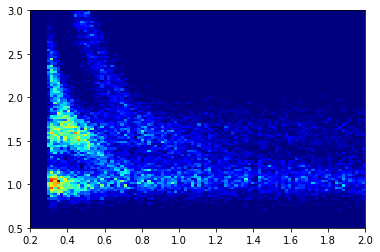

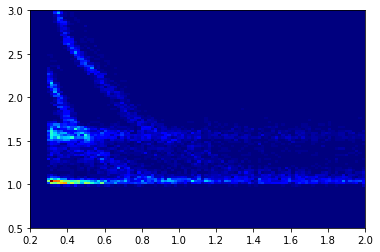

In [21]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC2_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# labels for missing tracks

In [22]:
train_in = train[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
train_out = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_in = test[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
test_out = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
scaler_in = StandardScaler()
scaler_out = StandardScaler()
scaler_in.fit(train_in)
scaler_out.fit(train_out)

QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
          output_distribution='uniform', random_state=None,
          subsample=100000)

In [23]:
modell.fit(scaler_in.transform(train_in), scaler_out.transform(train_out), epochs=5, batch_size=32, 
          validation_data=[scaler_in.transform(test_in),scaler_out.transform(test_out)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 7s 363us/step - loss: 0.0205 - mean_squared_error: 0.0205 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 2/5
20000/20000 [==============================] - 6s 280us/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 3/5
20000/20000 [==============================] - 5s 270us/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 4/5
20000/20000 [==============================] - 5s 272us/step - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 5/5
20000/20000 [==============================] - 5s 272us/step - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0127 - val_mean_squared_error: 0.0127


In [24]:
out = scaler_out.inverse_transform(modell.predict(scaler_in.transform(test_in)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
#test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

,level_0,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,...,TPCROC2_0,TRD_mr,TRD_w,TRD_0,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,0,10244,0.002864,1.035537,1.468154,1.576882,1.633345,1.399334,1.520442,2,...,1.633345,1.399334,1.0,1.399334,0.002667,1.022953,1.489205,1.521803,1.527904,1.548806
1,1,38092,0.003103,0.653779,2.108281,1.730810,1.889418,1.668988,0.375478,4,...,1.889418,1.668988,1.0,1.668988,0.003240,0.703695,1.764175,1.804085,1.807902,1.787099
2,2,1997,0.002626,1.082544,1.111228,1.293733,1.057884,1.240914,4.078123,0,...,1.057884,1.240914,1.0,1.240914,0.001913,1.046689,1.157092,1.168175,1.158128,1.174240


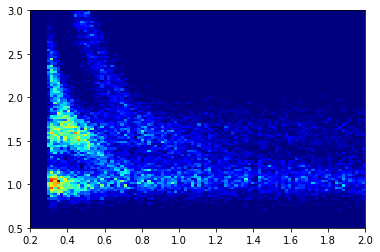

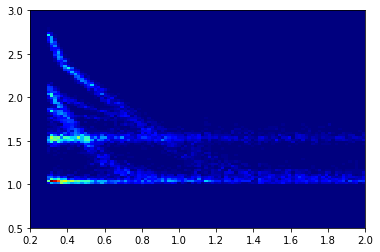

In [25]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# mean input, zero weights for missing values

In [26]:
train_mr = train[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
test_mr = test[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
train_w    = train[["ITS_w", "TOF_w", "TPCROC0_w", "TPCROC1_w", "TPCROC2_w", "TRD_w"]]
test_w     = test[["ITS_w", "TOF_w", "TPCROC0_w", "TPCROC1_w", "TPCROC2_w", "TRD_w"]]

In [27]:
scaler_mr = StandardScaler()
scaler_mr.fit(train_mr)

QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
          output_distribution='uniform', random_state=None,
          subsample=100000)

In [28]:
model1.fit([scaler_mr.transform(train_mr),train_w], scaler_mr.transform(train_mr), epochs=5, batch_size=32, 
          validation_data=[[scaler_mr.transform(test_mr),train_w],scaler_mr.transform(test_mr)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 7s 362us/step - loss: 0.0182 - mean_squared_error: 0.0216 - val_loss: 0.0137 - val_mean_squared_error: 0.0144
Epoch 2/5
20000/20000 [==============================] - 6s 277us/step - loss: 0.0182 - mean_squared_error: 0.0215 - val_loss: 0.0131 - val_mean_squared_error: 0.0138
Epoch 3/5
20000/20000 [==============================] - 6s 277us/step - loss: 0.0181 - mean_squared_error: 0.0213 - val_loss: 0.0133 - val_mean_squared_error: 0.0140
Epoch 4/5
20000/20000 [==============================] - 6s 276us/step - loss: 0.0182 - mean_squared_error: 0.0215 - val_loss: 0.0129 - val_mean_squared_error: 0.0136
Epoch 5/5
20000/20000 [==============================] - 6s 282us/step - loss: 0.0181 - mean_squared_error: 0.0214 - val_loss: 0.0138 - val_mean_squared_error: 0.0145


In [29]:
out = scaler_mr.inverse_transform(model1.predict([scaler_mr.transform(test_mr),test_w]))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
#test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

,level_0,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,...,TPCROC2_0,TRD_mr,TRD_w,TRD_0,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,0,10244,0.002864,1.035537,1.468154,1.576882,1.633345,1.399334,1.520442,2,...,1.633345,1.399334,1.0,1.399334,0.002636,0.991766,1.518721,1.549294,1.515958,1.526323
1,1,38092,0.003103,0.653779,2.108281,1.730810,1.889418,1.668988,0.375478,4,...,1.889418,1.668988,1.0,1.668988,0.003349,0.621060,1.839653,1.945360,1.905036,1.874454
2,2,1997,0.002626,1.082544,1.111228,1.293733,1.057884,1.240914,4.078123,0,...,1.057884,1.240914,1.0,1.240914,0.001886,1.036027,1.145494,1.177350,1.161160,1.134565


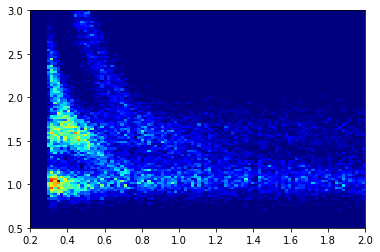

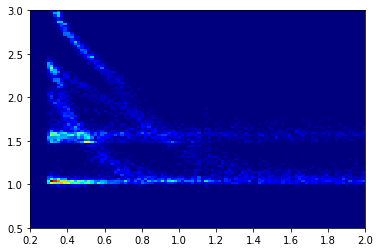

In [30]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# second iteration, replace missing values by values from first iteration

In [31]:
# stage 2
stage2_data = df_stage_2[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
out = scaler_mr.inverse_transform(models2.predict(scaler_mr.transform(stage2_data)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
for i ,name in enumerate(['ITS','TOF','TPCROC0','TPCROC1','TPCROC2','TRD']):
    # calculate "flip= 0/1"
    f=(np.array(df_stage_2['flips'])>>i)&1
    m=AE_predict[name+'_ae']
    df_stage_2.loc[:,name+'_s2']= df_stage_2[name].multiply(f,axis='index')+m*(1-f)

In [32]:
train, test =train_test_split(df_stage_2, test_size=0.5)
train_s2 = train[["ITS_s2", "TOF_s2", "TPCROC0_s2", "TPCROC1_s2", "TPCROC2_s2", "TRD_s2"]]
test_s2 = test[["ITS_s2", "TOF_s2", "TPCROC0_s2", "TPCROC1_s2", "TPCROC2_s2", "TRD_s2"]]

In [33]:
scaler_s2 = StandardScaler()
scaler_s2.fit(train_s2)
models2.fit(scaler_s2.transform(train_s2), scaler_s2.transform(train_s2), epochs=5, batch_size=32, 
          validation_data=[scaler_s2.transform(test_s2),scaler_s2.transform(test_s2)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 8s 379us/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 2/5
20000/20000 [==============================] - 6s 282us/step - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 3/5
20000/20000 [==============================] - 6s 280us/step - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 4/5
20000/20000 [==============================] - 6s 276us/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 5/5
20000/20000 [==============================] - 6s 282us/step - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0109 - val_mean_squared_error: 0.0109


In [34]:
out = scaler_s2.inverse_transform(models2.predict(scaler_s2.transform(test_s2)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips,...,TPCROC0_s2,TPCROC1_s2,TPCROC2_s2,TRD_s2,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,21546,0.001756,0.788007,1.051440,1.067432,1.041700,1.188785,6.384989,3,63,...,1.051440,1.067432,1.041700,1.188785,0.001776,0.905763,1.064749,1.068360,1.065892,1.068910
1,37292,0.001611,0.796185,1.066312,1.126025,0.822468,0.924678,1.112189,4,63,...,1.066312,1.126025,0.822468,0.924678,0.001726,0.908386,1.030552,1.032142,1.032937,1.036635
2,7147,0.001449,0.875710,1.021376,1.045734,1.128446,1.101254,0.325549,0,63,...,1.021376,1.045734,1.128446,1.101254,0.001744,0.924878,1.045920,1.046267,1.046983,1.048801


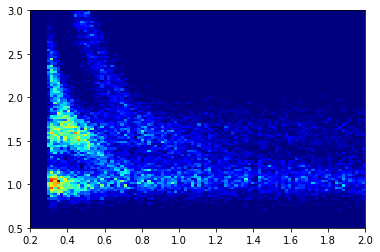

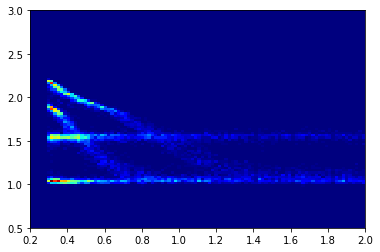

In [35]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()